In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

from fault_tolerant_ml.data import OccupancyData
from fault_tolerant_ml.data import MNist
from fault_tolerant_ml.ml.optimizer import SGDOptimizer

plt.style.use("ggplot")

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [7]:
data = OccupancyData(filepath="/c/Users/nb304836/Documents/git-repos/large_scale_ml/data/occupancy_data/datatraining.txt")

In [8]:
data.X.shape

(12828, 5)

In [9]:
data.transform()

In [11]:
theta = np.random.randn(5, 1)
min_theta_val = theta.min() + 1e-8
max_theta_val = theta.max() + 1e-8
interval = 8
bins = np.linspace(min_theta_val, max_theta_val, interval)
theta_bins = np.digitize(theta, bins).astype(np.int8)

struct_field_names = ["min_val", "max_val", "interval", "bins"]
struct_field_types = [np.float32, np.float32, np.int32, 'b']
struct_field_shapes = [1, 1, 1, (theta.shape)]

In [12]:
data = np.zeros(1, dtype=(list(zip(struct_field_names, struct_field_types, struct_field_shapes))))

In [13]:
data[0] = (min_theta_val, max_theta_val, interval, theta_bins)    

In [14]:
data

array([(-0.9147906, 0.4296553, 8, [[4], [2], [7], [0], [3]])],
      dtype=[('min_val', '<f4'), ('max_val', '<f4'), ('interval', '<i4'), ('bins', 'i1', (5, 1))])

## Mnist Logistic regression

In [448]:
data_dir = "/c/Users/nb304836/Documents/git-repos/fault_tolerant_ml/data/"
filepaths = {
    "train": {
        "images": os.path.join(data_dir, "train-images-idx3-ubyte.gz"), "labels": os.path.join(data_dir, "train-labels-idx1-ubyte.gz")
    },
    "test": {
        "images": os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "labels": os.path.join(data_dir, "t10k-labels-idx1-ubyte.gz")
    }
}

In [449]:
mnist = MNist(filepaths)

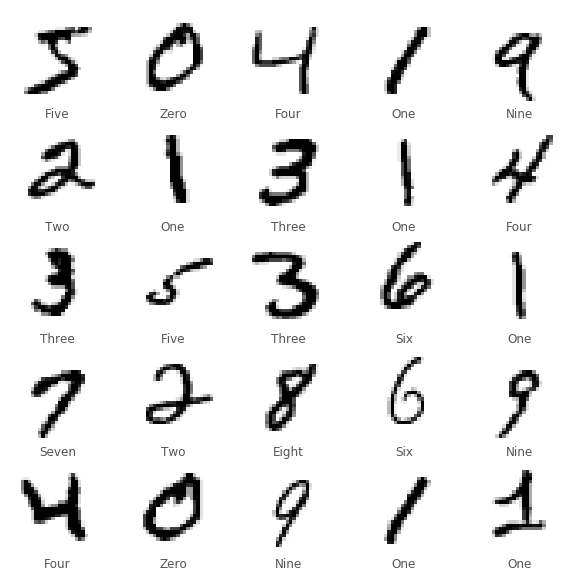

In [450]:
plt.figure(figsize=(10,10))
labels = np.argmax(mnist.y_train, axis=1)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist.X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(mnist.class_names[labels[i]])
plt.show()

In [25]:
from fault_tolerant_ml.tools import WatchDog
from fault_tolerant_ml.tools.watch_dog import WorkerStates

In [32]:
worker_states = WorkerStates()

In [33]:
worker_states.add_worker(b"worker-1")

In [35]:
worker_states()

{b'worker-1': <WorkerState identity=worker-1>}

In [36]:
watch_dog = WatchDog()

In [37]:
watch_dog.n_alive

0

In [451]:
from fault_tolerant_ml.ml.loss_fns import cross_entropy_loss, cross_entropy_gradient
from fault_tolerant_ml.ml.linear_model import LogisticRegression

In [458]:
optimizer = SGDOptimizer(cross_entropy_loss, cross_entropy_gradient, learning_rate=0.9)

In [459]:
lr = LogisticRegression(optimizer=optimizer, max_iter=75)

In [460]:
lr.fit(mnist.X_train, mnist.y_train)

Iteration=0, delta=0.42986221568153327, loss=inf
Iteration=1, delta=0.08888491445854863, loss=1.4394984503884933
Iteration=2, delta=0.07220820442036535, loss=1.1834059239349592
Iteration=3, delta=0.05703214934004586, loss=1.0278727048715093
Iteration=4, delta=0.05246974813037997, loss=0.9315479349298509
Iteration=5, delta=0.046731211671285244, loss=0.8612265631344751
Iteration=6, delta=0.0429493594139998, loss=0.8042451363964818
Iteration=7, delta=0.04112036268642616, loss=0.756016766908177
Iteration=8, delta=0.03955017987998111, loss=0.7146344284181327
Iteration=9, delta=0.0379850073809076, loss=0.6788290501875724
Iteration=10, delta=0.036392957409543514, loss=0.6476088821983521
Iteration=11, delta=0.034785011791138465, loss=0.620188447105567
Iteration=12, delta=0.033178289368908764, loss=0.5959419711744182
Iteration=13, delta=0.0317277101052732, loss=0.5743664139521982
Iteration=14, delta=0.030684118436069552, loss=0.5550548137879286
Iteration=15, delta=0.029620710835259967, loss=0.5

In [461]:
labels = lr.predict(mnist.X_test)

In [462]:
y_pred = labels.argmax(axis=1)

In [463]:
y = mnist.y_test.argmax(axis=1)

In [464]:
np.sum(y_pred==y) / y.shape[0]

0.7729

In [100]:
from fault_tolerant_ml.ml.utils.math.autodiff import Dual
from fault_tolerant_ml.ml.loss_fns import cross_entropy_loss, cross_entropy_gradient
from fault_tolerant_ml.ml.utils import maths_utils
# import math

In [37]:
x = Dual(np.array([5, 2]), 1)
y = Dual(6)

In [38]:
f = Dual.pow(x, 2) * y

In [39]:
f.derivative

array([60, 24])

In [40]:
h = Dual(np.array([0.1, 0.3, 0.6]), 1)
y = Dual(np.array([0, 1, 1]))

In [41]:
cross_entropy_loss(h._val, y._val)

0.6067196479165844

In [42]:
# cross_entropy_gradient()

In [44]:
f

In [45]:
f = -y * Dual.log(h) - (Dual(1) - y) * Dual.log(Dual(1) - h)

In [49]:
f.mean().derivative

-1.2962962962962965

In [138]:
from autograd import grad
# import autograd.numpy as np

In [405]:
n_samples, n_features = mnist.X_train.shape

In [407]:
_, n_classes = mnist.y_train.shape

In [408]:
weights = np.random.randn(n_features, n_classes)

In [410]:
weights.shape

(784, 10)

In [411]:
def sigmoid(s):
    return 1. / 1. + np.exp(-s)

In [412]:
def loss(weights):
    s = np.dot(X, weights)
    y_pred = sigmoid(s)
    return np.mean(-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred))    

In [414]:
s = np.dot(mnist.X_train, weights)
y_pred = sigmoid(s)

In [415]:
l = cross_entropy_loss(y_pred, mnist.y_train)

/c/Users/nb304836/Documents/git-repos/fault_tolerant_ml/fault_tolerant_ml/ml/loss_fns.py:5: RuntimeWarning: divide by zero encountered in log
  return -y * np.log(h) - (1 - y) * np.log(1 - h)
/c/Users/nb304836/Documents/git-repos/fault_tolerant_ml/fault_tolerant_ml/ml/loss_fns.py:5: RuntimeWarning: invalid value encountered in log
  return -y * np.log(h) - (1 - y) * np.log(1 - h)


In [416]:
l

nan

In [420]:
np.dot(mnist.X_train.T, mnist.y_train - y_pred) / mnist.X_train.shape[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [426]:
d_theta = np.zeros((n_features, n_classes))

In [427]:
for k in np.arange(n_classes):
    d_theta[:, k] = cross_entropy_gradient(mnist.X_train, (mnist.y_train - y_pred)[:, np.newaxis, k])

In [432]:
return_params = (1, 2)

In [436]:
(3, ) + return_params

(3, 1, 2)

In [428]:
d_theta.shape

(784, 10)

In [365]:
loss(weights)

nan

In [366]:
grad_fn = grad(loss)

In [367]:
grad_fn(weights)

array([[-0.41861879],
       [ 0.36414266],
       [-0.22397139]])

In [374]:
losses =[]
for i in range(100):
    l = loss(weights)
    weights -= grad_fn(weights) * 0.01
    losses.append(l)

In [369]:
import matplotlib.pyplot as plt

In [471]:
() + (1, )

(1,)

In [472]:
def decorator_with_arguments(function):
    def wrapper_accepting_arguments(arg1, arg2):
        print("My arguments are: {0}, {1}".format(arg1,arg2))
        function(arg1, arg2)
    return wrapper_accepting_arguments


@decorator_with_arguments
def cities(city_one, city_two):
    print("Cities I love are {0} and {1}".format(city_one, city_two))

cities("Nairobi", "Accra")

My arguments are: Nairobi, Accra
Cities I love are Nairobi and Accra


In [474]:
def ftml_train(function):
    def wrapper():
        print("Running if statement")
        action = True
        if action:
            function()
    return wrapper

In [475]:
@ftml_train
def train_iteration():
    theta = np.random.randn(5, 2)

In [477]:
i = 0
while i < 2:
    train_iteration()
    i += 1

Running if statement
Running if statement


In [482]:
X = np.random.randint(0, 10, size=(3, 3))

In [483]:
X

array([[8, 1, 9],
       [8, 6, 3],
       [9, 4, 5]])

In [487]:
msg = X.tostring()
dtype = X.dtype
shape = str(X.shape)

In [493]:
def concat(data):
    
    x = [b"", b"WORK"]
    x.extend(data)
    return x

In [494]:
x = concat([msg, dtype, shape])
x

[b'',
 b'WORK',
 b'\x08\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\t\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\t\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00',
 dtype('int64'),
 '(3, 3)']

In [495]:
def replacing_decorator_with_args(arg):
    print("defining the decorator")
    def _decorator(function):
        # in this inner function, arg is available too
        print("doing decoration, %r" % arg)
        def _wrapper(*args, **kwargs):
            print("inside wrapper, %r %r" % (args, kwargs))
            return function(*args, **kwargs)
        return _wrapper
    return _decorator

@replacing_decorator_with_args("abc")
def function(*args, **kwargs):
    print("inside function, %r %r" % (args, kwargs))
    return 14

defining the decorator
doing decoration, 'abc'


In [496]:
function(11, 12)

inside wrapper, (11, 12) {}
inside function, (11, 12) {}


14

In [19]:
interval = 100

In [20]:
theta = np.random.randn(784, 10)

In [21]:
min_theta_val = theta.min() + 1e-8
max_theta_val = theta.max() + 1e-8
bins = np.linspace(min_theta_val, max_theta_val, interval)
theta_bins = np.digitize(theta, bins).astype(np.int8)

struct_field_names = ["min_val", "max_val", "interval", "bins"]
struct_field_types = [np.float32, np.float32, np.int32, 'b']
struct_field_shapes = [1, 1, 1, (theta.shape)]

msg = np.zeros(1, dtype=(list(zip(struct_field_names, struct_field_types, struct_field_shapes))))
msg[0] = (min_theta_val, max_theta_val, interval, theta_bins)

In [22]:
msg.nbytes

7852

In [23]:
theta.nbytes

62720

In [24]:
bins

array([-3.41736523, -3.33360606, -3.24984688, -3.16608771, -3.08232854,
       -2.99856936, -2.91481019, -2.83105102, -2.74729184, -2.66353267,
       -2.57977349, -2.49601432, -2.41225515, -2.32849597, -2.2447368 ,
       -2.16097763, -2.07721845, -1.99345928, -1.90970011, -1.82594093,
       -1.74218176, -1.65842258, -1.57466341, -1.49090424, -1.40714506,
       -1.32338589, -1.23962672, -1.15586754, -1.07210837, -0.9883492 ,
       -0.90459002, -0.82083085, -0.73707168, -0.6533125 , -0.56955333,
       -0.48579415, -0.40203498, -0.31827581, -0.23451663, -0.15075746,
       -0.06699829,  0.01676089,  0.10052006,  0.18427923,  0.26803841,
        0.35179758,  0.43555676,  0.51931593,  0.6030751 ,  0.68683428,
        0.77059345,  0.85435262,  0.9381118 ,  1.02187097,  1.10563014,
        1.18938932,  1.27314849,  1.35690766,  1.44066684,  1.52442601,
        1.60818519,  1.69194436,  1.77570353,  1.85946271,  1.94322188,
        2.02698105,  2.11074023,  2.1944994 ,  2.27825857,  2.36

In [2]:
unique = np.array([1, 2, 3, 4, 5, 6])

In [3]:
dist = np.array([800, 754, 804, 853, 740, 790])

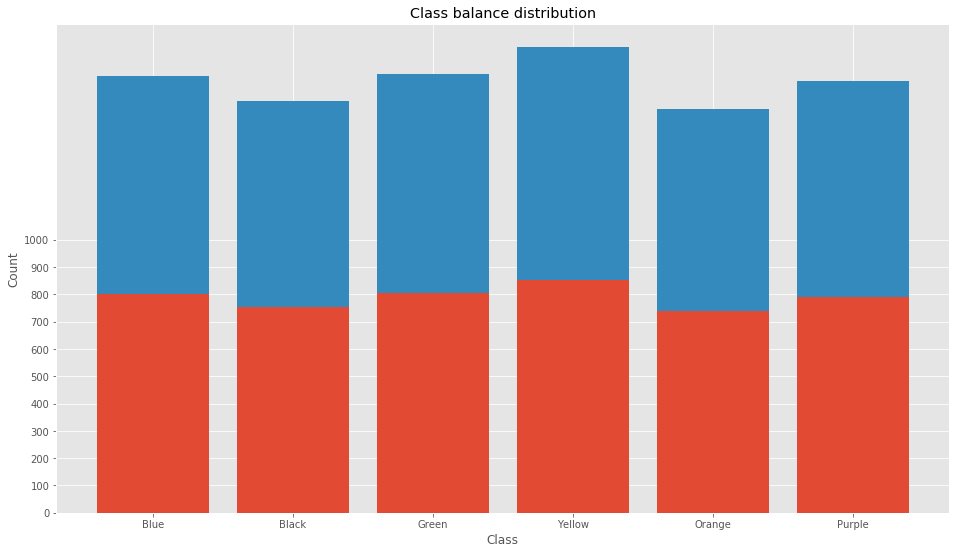

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
axes.bar(unique, dist)
axes.bar(unique, dist, bottom=dist)
axes.set_xticks(np.array([1, 2, 3, 4, 5, 6]))
axes.set_xticklabels(labels=["Blue", "Black", "Green", "Yellow", "Orange", "Purple"])
axes.set_title("Class balance distribution")
axes.set_xlabel("Class")
axes.set_ylabel("Count")
axes.set_yticks(np.arange(0, 1100, 100))
# plt.savefig()

In [23]:
labels_per_worker = {}
for i in np.arange(7):
    labels_per_worker[i] = np.random.randint(750, 900, size=(10,))

In [24]:
labels_per_worker

{0: array([813, 879, 796, 868, 784, 823, 865, 819, 776, 872]),
 1: array([894, 762, 852, 819, 788, 851, 756, 791, 875, 760]),
 2: array([799, 859, 861, 837, 773, 885, 774, 878, 853, 809]),
 3: array([750, 783, 846, 791, 801, 791, 894, 809, 773, 756]),
 4: array([859, 866, 875, 771, 774, 778, 839, 891, 767, 816]),
 5: array([840, 779, 893, 864, 858, 752, 761, 869, 788, 797]),
 6: array([808, 792, 899, 828, 844, 833, 883, 794, 847, 796])}

In [ ]:
pd.DataFrame()

Text(0.5, 1.0, 'Testing')

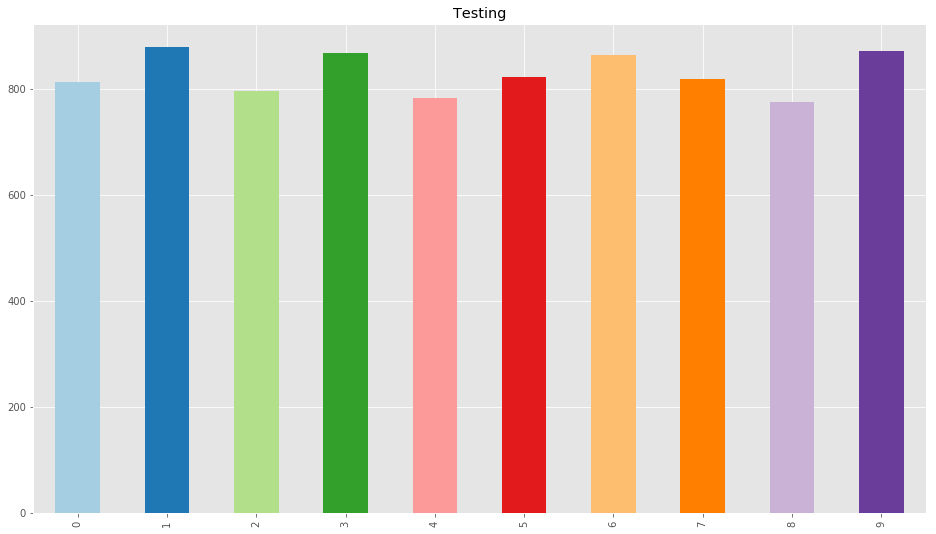

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ser = pd.Series(labels_per_worker[0])
ser.T.plot(kind="bar", ax=ax, color=plt.cm.Paired(np.arange(len(ser))))
ax.set_title("Testing")

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
bottom = None
for k, v in labels_per_worker.items():
    axes.bar(unique, v, bottom=bottom)
    bottom = 

0 [813 879 796 868 784 823 865 819 776 872]
1 [894 762 852 819 788 851 756 791 875 760]
2 [799 859 861 837 773 885 774 878 853 809]
3 [750 783 846 791 801 791 894 809 773 756]
4 [859 866 875 771 774 778 839 891 767 816]
5 [840 779 893 864 858 752 761 869 788 797]
6 [808 792 899 828 844 833 883 794 847 796]


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
axes.bar(unique, dist)
axes.bar(unique, dist, bottom=dist)
axes.set_xticks(np.array([1, 2, 3, 4, 5, 6]))
axes.set_xticklabels(labels=["Blue", "Black", "Green", "Yellow", "Orange", "Purple"])
axes.set_title("Class balance distribution")
axes.set_xlabel("Class")
axes.set_ylabel("Count")
axes.set_yticks(np.arange(0, 1100, 100))

In [42]:
labels_per_worker

{0: array([813, 879, 796, 868, 784, 823, 865, 819, 776, 872]),
 1: array([894, 762, 852, 819, 788, 851, 756, 791, 875, 760]),
 2: array([799, 859, 861, 837, 773, 885, 774, 878, 853, 809]),
 3: array([750, 783, 846, 791, 801, 791, 894, 809, 773, 756]),
 4: array([859, 866, 875, 771, 774, 778, 839, 891, 767, 816]),
 5: array([840, 779, 893, 864, 858, 752, 761, 869, 788, 797]),
 6: array([808, 792, 899, 828, 844, 833, 883, 794, 847, 796])}

In [44]:
l = {}
l[0] = (np.array([0, 1, 3]), np.array([1, 4, 15]))
l[1] = (np.array([4]), np.array([20]))
l[2] = (np.array([0, 4, 5, 7, 9]), np.array([3, 3, 8, 4, 2]))
l[3] = (np.array([1, 3, 7, 9]), np.array([7, 6, 4, 3]))

In [52]:
for i in np.arange(7):
    if i in l.keys():
        classes, dists = l[i]
        labels_per_worker[i][classes] = labels_per_worker[i][classes] + dists
        
labels_per_worker

{0: array([814, 883, 796, 883, 784, 823, 865, 819, 776, 872]),
 1: array([894, 762, 852, 819, 808, 851, 756, 791, 875, 760]),
 2: array([802, 859, 861, 837, 776, 893, 774, 882, 853, 811]),
 3: array([750, 790, 846, 797, 801, 791, 894, 813, 773, 759]),
 4: array([859, 866, 875, 771, 774, 778, 839, 891, 767, 816]),
 5: array([840, 779, 893, 864, 858, 752, 761, 869, 788, 797]),
 6: array([808, 792, 899, 828, 844, 833, 883, 794, 847, 796])}

In [56]:
scenario = 2
if (scenario != 2) and (not labels_per_worker):
    print("hi")
else:
    print("goodbye")

goodbye
